In [131]:
import random
import pandas as pd
import tqdm

### Discount

In [132]:
# net annual earnings - https://doi.org/10.2908/EARN_NT_NET

In [133]:
earnings_df = pd.read_csv('net_earnings_eu.tsv', sep = '\t')[['freq,currency,estruct,ecase,geo\TIME_PERIOD', '2022 ']]
earnings_df.columns = ['segment', 'country_avg_annual_earning']
earnings_df['country_code'] = earnings_df['segment'].map(lambda x: x.split(',')[-1])
earnings_df = earnings_df.drop('segment', axis = 1)
earnings_df = earnings_df[['country_code', 'country_avg_annual_earning']]

In [134]:
# population - https://doi.org/10.2908/TPS00001

In [135]:
population_df = pd.read_csv('population.tsv', sep = '\t')[['freq,indic_de,geo\TIME_PERIOD', '2023 ']]
population_df.columns = ['segment', 'country_population']
population_df['country_code'] = population_df['segment'].map(lambda x: x.split(',')[-1])
population_df = population_df.drop('segment', axis = 1)
population_df = population_df[['country_code', 'country_population']]

In [136]:
iso_df = pd.read_csv('iso_codes.txt')[['name', 'alpha-2']]
iso_df.columns = ['country', 'country_code']

In [137]:
house_hold_size_distribution = {
    1: 0.3,
    2: 0.35,
    3: 0.17,
    4: 0.12,
    5: 0.06
}

In [138]:
country_df = earnings_df.merge(population_df)

In [139]:
country_df = country_df[(country_df.country_avg_annual_earning != ': ') & (country_df.country_population != ': ')]

In [140]:
country_df = country_df[~country_df.country_code.isin(['EA19', 'EA20', 'EU27_2020'])]

In [141]:
country_df['country_avg_annual_earning'] = country_df.country_avg_annual_earning.map(
    lambda x: float(x.split(' ')[0])
)

country_df['country_population'] = country_df.country_population.map(
    lambda x: int(x.split(' ')[0])
)

In [142]:
country_df = country_df.merge(iso_df, how = 'left')

In [143]:
country_df['population_weight'] = country_df.country_population/country_df.country_population.sum()

In [144]:
country_df = country_df.sort_values('country_population', ascending = False)

In [145]:
country_df.head()

,country_code,country_avg_annual_earning,country_population,country,population_weight
30,TR,9269.70,85279553,Turkey,0.16
6,DE,66635.37,84358845,Germany,0.15
12,FR,56701.01,68070697,France,0.12
17,IT,44546.06,58850717,Italy,0.11
10,ES,36840.03,48059777,Spain,0.09


In [146]:
import numpy as np

In [147]:
before_audience = round(country_df.country_population.sum()*0.00042*np.random.normal(1, 0.1))
after_audience = round(country_df.country_population.sum()*0.00042*np.random.normal(1.1, 0.1))
before_audience, after_audience

(205369, 256270)

In [148]:
tmp_data = []
for user_id in tqdm.tqdm(range(before_audience)):
    tmp_data.append(
        {
            'user_id': user_id,
            'country': random.choices(country_df.country.values, country_df.population_weight.values)[0],
            'num_family_members': random.choices(list(house_hold_size_distribution.keys()), house_hold_size_distribution.values())[0]
        }
    )

before_df = pd.DataFrame(tmp_data)

100%|██████████████████████████████████████████████████████████| 205369/205369 [00:01<00:00, 105435.36it/s]


In [149]:
tmp_data = []
for user_id in tqdm.tqdm(range(after_audience)):
    tmp_data.append(
        {
            'user_id': user_id,
            'country': random.choices(country_df.country.values, country_df.population_weight.values)[0],
            'num_family_members': random.choices(list(house_hold_size_distribution.keys()), house_hold_size_distribution.values())[0]
        }
    )

after_df = pd.DataFrame(tmp_data)

100%|██████████████████████████████████████████████████████████| 256270/256270 [00:02<00:00, 104248.87it/s]


In [150]:
before_df['period'] = '2024-01-01'
after_df['period'] = '2024-02-01'

In [151]:
df = pd.concat([before_df, after_df])

In [152]:
df.country.value_counts(normalize=True).head(10)

country
Turkey         0.16
Germany        0.15
France         0.12
Italy          0.11
Spain          0.09
Poland         0.07
Romania        0.03
Netherlands    0.03
Belgium        0.02
Czechia        0.02
Name: proportion, dtype: float64

In [153]:
df.num_family_members.value_counts(normalize=True)

num_family_members
2    0.35
1    0.30
3    0.17
4    0.12
5    0.06
Name: proportion, dtype: float64

In [154]:
df = df.merge(country_df[['country', 'country_avg_annual_earning']])

In [155]:
def get_treatment_group(period):
    if period == '2024-01-01':
        return 0
    return 1 if random.random() > 0.5 else 0

df['treatment'] = df.period.map(get_treatment_group)

In [156]:
df.groupby(['period', 'treatment'], as_index = False).user_id.count()

,period,treatment,user_id
0,2024-01-01,0,205369
1,2024-02-01,0,128055
2,2024-02-01,1,128215


In [157]:
def get_retention(treatment, num_family_members):
    rand = random.random()
    if treatment == 1:
        if rand <= 0.623 + 0.025*num_family_members:
            return 1
        else:
            return 0
    else:
        if rand <= 0.5846 + 0.025*num_family_members:
            return 1
        else:
            return 0

In [176]:
0.5846 - 0.623

-0.03839999999999999

In [158]:
df['retention'] = list(map(
    get_retention,
    df.treatment, 
    df.num_family_members
))

In [159]:
df.groupby('treatment').retention.mean()

treatment
0    0.64
1    0.68
Name: retention, dtype: float64

In [168]:
def get_value(treatment, retention, num_family_members, country_avg_annual_earning):
    if retention == 0:
        return 0.0
    salary_share = np.random.beta(8, 72)
    value = country_avg_annual_earning * salary_share /12 * (1 + np.random.normal(0.2, 0.03)*num_family_members)
    if treatment == 1:
        value += np.random.normal(20, 10)
    return value

In [169]:
df['customer_value'] = list(map(
    get_value,
    df.treatment,
    df.retention,
    df.num_family_members,
    df.country_avg_annual_earning
))

In [170]:
df.customer_value.max()

4265.3700802594685

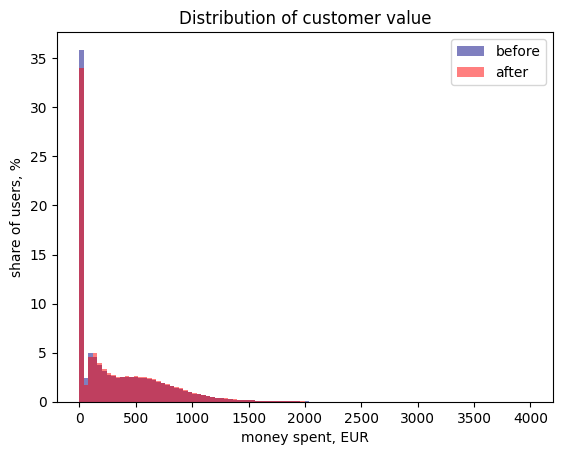

In [171]:
from matplotlib import pyplot

hist_range = [0, 4000]
hist_bins = 100

pyplot.hist(
    df[df.period == '2024-01-01'].customer_value.values,
    label = 'before',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    # calculating weights to get normalised histogram
    weights = np.ones_like(df[df.period == '2024-01-01'].index)*100/df[df.period == '2024-01-01'].shape[0]
)

pyplot.hist(
    df[df.period == '2024-02-01'].customer_value.values,
    label = 'after',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'red',
    # calculating weights to get normalised histogram
    weights = np.ones_like(df[df.period == '2024-02-01'].index)*100/df[df.period == '2024-02-01'].shape[0]
)

pyplot.legend(loc = 'upper right')
pyplot.title('Distribution of customer value')
pyplot.xlabel('money spent, EUR')
pyplot.ylabel('share of users, %')
pyplot.show()

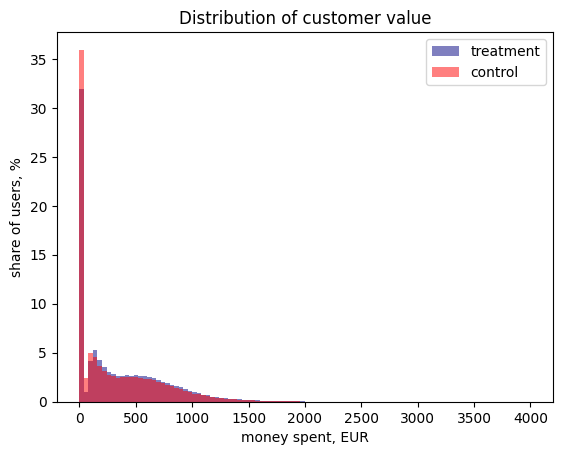

In [172]:
from matplotlib import pyplot

hist_range = [0, 4000]
hist_bins = 100

pyplot.hist(
    df[df.treatment == 1].customer_value.values,
    label = 'treatment',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'navy',
    # calculating weights to get normalised histogram
    weights = np.ones_like(df[df.treatment == 1].index)*100/df[df.treatment == 1].shape[0]
)

pyplot.hist(
    df[df.treatment == 0].customer_value.values,
    label = 'control',
    alpha = 0.5, range = hist_range, bins = hist_bins,
    color = 'red',
    # calculating weights to get normalised histogram
    weights = np.ones_like(df[df.treatment == 0].index)*100/df[df.treatment == 0].shape[0]
)

pyplot.legend(loc = 'upper right')
pyplot.title('Distribution of customer value')
pyplot.xlabel('money spent, EUR')
pyplot.ylabel('share of users, %')
pyplot.show()

In [173]:
df.to_csv('discount_experiment_synthetic_v2.csv', index = False)

In [174]:
pd.set_option('display.precision', 2)

In [175]:
df.sample(5)

,user_id,country,num_family_members,period,country_avg_annual_earning,treatment,retention,customer_value
282602,202800,France,4,2024-02-01,56701.01,1,0,0.00
95568,96777,Spain,3,2024-01-01,36840.03,0,1,703.98
101223,161897,Spain,3,2024-01-01,36840.03,0,1,368.05
423861,80310,Switzerland,2,2024-02-01,106839.33,1,1,1090.02
6840,200661,Romania,1,2024-01-01,14500.29,0,1,92.63
